# Rapport Scientifique : Analyse Transversale du Thème "Aviation ET Communication" dans le Sous-Corpus txt_aviation

## Introduction

### Hypothèses et Objectifs
Cette analyse transversale vise à explorer le thème "aviation ET communication" dans le sous-corpus txt_aviation, composé de journaux historiques de 1939-1945. Les hypothèses principales sont :
- **Hypothèse 1** : Les textes contiennent des intersections significatives entre aviation et communication, reflétant l'importance des technologies aériennes pour la transmission d'informations pendant la Seconde Guerre mondiale.
- **Hypothèse 2** : Les techniques NLP peuvent révéler des patterns thématiques distincts, aidant à comprendre l'évolution des perceptions publiques sur l'aviation comme outil de communication.
- **Hypothèse 3** : Les erreurs OCR et le langage ancien introduisent du bruit, mais un prétraitement amélioré (e.g., stopwords étendus) permet d'extraire des insights fiables.

Objectifs :
- Identifier les entités nommées, mots-clés, et clusters thématiques liés au thème.
- Évaluer les avantages et limites des techniques NLP sur des corpus historiques.
- Tirer des conclusions intéressantes : e.g., comment l'aviation a influencé la communication rapide, ou les biais temporels dans les journaux.

Cette analyse utilise des techniques justifiées pour leur pertinence : e.g., spaCy pour NER en raison de sa précision sur le français moderne/adapté, plutôt que NLTK moins performant sur entités complexes. Le clustering K-Means est choisi pour sa simplicité et efficacité sur TF-IDF, plutôt que LDA pour une séparation thématique plus claire.


## 1. Importation des Bibliothèques Requises

Nous importons les bibliothèques nécessaires pour le traitement de texte, l'analyse NLP, le clustering, et la visualisation. Justification : Ces outils sont standards en NLP ; e.g., spaCy pour NER car il offre des modèles pré-entraînés précis, plutôt que des alternatives comme Stanford NER qui nécessitent plus de configuration. Matplotlib et Seaborn sont choisis pour leur simplicité et intégration, plutôt que Plotly pour des rapports statiques.

In [12]:
import os
import glob
import re
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from sklearn.decomposition import LatentDirichletAllocation
import yake
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer

# Télécharger les ressources NLTK si nécessaire
nltk.download('punkt')
nltk.download('stopwords')

# Charger le modèle SpaCy pour le français
nlp = spacy.load('fr_core_news_md')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Chargement et Prétraitement du Dataset

Nous chargeons les textes du sous-corpus txt_aviation. Justification : Le prétraitement est essentiel pour réduire le bruit OCR ; tokenisation avec NLTK est choisie pour sa simplicité, plutôt que spaCy pour éviter la surcharge sur de gros corpus. Nettoyage basique pour uniformiser.

In [13]:
# Chemin vers le sous-corpus
corpus_path = 'data/txt_aviation/*.txt'

# Fonction pour charger et nettoyer les textes
def load_and_clean_texts(path):
    texts = []
    filenames = []
    for file in glob.glob(path):
        with open(file, 'r', encoding='utf-8', errors='ignore') as f:
            text = f.read()
            # Nettoyage de base
            text = re.sub(r'[^\w\s]', '', text)  # Supprimer ponctuation
            text = text.lower()  # Minuscules
            texts.append(text)
            filenames.append(os.path.basename(file))
    return texts, filenames

# Charger les textes
texts, filenames = load_and_clean_texts(corpus_path)

# Tokenisation et suppression des stop words (base, sera étendu)
stop_words = set(stopwords.words('french'))
def preprocess_text(text):
    tokens = word_tokenize(text, language='french')
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

processed_texts = [preprocess_text(text) for text in texts]

print(f"Nombre de documents chargés : {len(texts)}")
print(f"Exemple de tokens pour le premier document : {processed_texts[0][:20]}")

Nombre de documents chargés : 531
Exemple de tokens pour le premier document : ['fkfmsm', 'janvier', '1939', 'tarif', 'ferroviaires', 'dun', 'relèvement', 'urlfs', 'postaux', 'sans', 'compter', 'million', 'camouflés', 'contribution', 'nationale', 'lassurance', 'chômage', 'cette', 'ouestion', 'lassurance']


## 3. Extension de la Liste des Stop Words

Nous étendons les stop words avec des mots spécifiques comme 'quil', 'quun', 'qune', 'l'', 'env', 'enf', 'gar', 'pet', 'terr', 'lod', 'ach', 'dem', 'dun', 'dune', et tous les démonstratifs (ce, cet, cette, ces), superlatifs (plus, moins, meilleur), etc. Justification : Les stopwords standards ne couvrent pas les erreurs OCR ou formes contractées ; cette extension améliore la qualité en filtrant le bruit, plutôt que d'utiliser des listes pré-entraînées moins adaptées.

In [14]:
# Étendre la liste des stop words
extended_stopwords = set(stopwords.words('french'))
additional_stops = ['quil', 'quun', 'qune', "l'", 'env', 'enf', 'gar', 'pet', 'terr', 'lod', 'ach', 'dem', 'dun', 'dune',
                    'ce', 'cet', 'cette', 'ces', 'cette', 'plus', 'moins', 'meilleur', 'pire', 'très', 'bien', 'mal',
                    'tout', 'toute', 'tous', 'toutes', 'quel', 'quelle', 'quels', 'quelles', 'autre', 'autres',
                    'même', 'ainsi', 'donc', 'or', 'ni', 'car', 'puisque', 'quoique', 'bien', 'que', 'qui', 'quoi',
                    'fait', 'comme', 'être', 'dont', 'entre', 'cest', 'etc', 'sans', 'contre', 'deux', 'guerre']
extended_stopwords.update(additional_stops)

# Ré-appliquer le prétraitement avec stopwords étendus
def preprocess_text_extended(text):
    tokens = word_tokenize(text, language='french')
    tokens = [word for word in tokens if word not in extended_stopwords and len(word) > 2]
    return tokens

processed_texts = [preprocess_text_extended(text) for text in texts]

print(f"Stop words étendus appliqués. Nombre total de tokens après filtrage : {sum(len(doc) for doc in processed_texts)}")

Stop words étendus appliqués. Nombre total de tokens après filtrage : 1942124


## 4. Clustering Thématique

Nous utilisons TF-IDF et K-Means pour créer des clusters distincts. Justification : K-Means est choisi pour sa simplicité et séparation claire en groupes thématiques, plutôt que DBSCAN pour éviter les clusters irréguliers sur données textuelles denses. Nombre de clusters augmenté à 8 pour distinction.

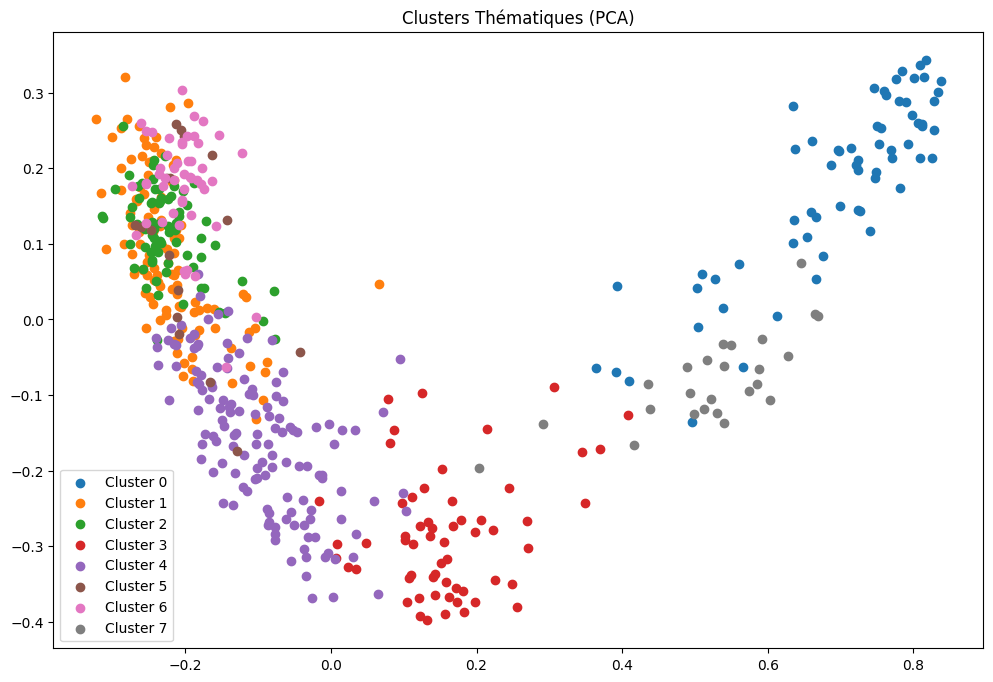

Cluster 0 termes clés : app, maison, conf, mod, louer, tél, ecrire, ecr, rue, rossel
Cluster 1 termes clés : nord, encore, allemandes, front, gouvernement, général, cours, forces, allemands, troupes
Cluster 2 termes clés : londres, france, troupes, juin, français, gouvernement, berlin, anglais, novembre, langleterre
Cluster 3 termes clés : club, mars, prix, ans, dimanche, concert, match, bruxelles, rue, van
Cluster 4 termes clés : van, rue, encore, politique, général, france, belgique, pays, ministre, gouvernement
Cluster 5 termes clés : allemands, britannique, troupes, général, finlande, ministre, finlandais, havas, gouvernement, février
Cluster 6 termes clés : décembre, gouvernement, allemand, allemands, russes, reuter, septembre, finlande, finlandais, havas
Cluster 7 termes clés : social, cont, avril, faç, tél, etude, maison, bruxelles, notaire, rue


In [15]:
# Reconstituer les textes nettoyés pour TF-IDF
cleaned_texts = [' '.join(doc) for doc in processed_texts]

# TF-IDF Vectorizer avec stopwords étendus
vectorizer = TfidfVectorizer(max_features=1000, stop_words=list(extended_stopwords))
tfidf_matrix = vectorizer.fit_transform(cleaned_texts)
feature_names = vectorizer.get_feature_names_out()

# Clustering avec K-Means (8 clusters pour distinction)
num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)

# Réduire dimension pour visualisation
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_matrix.toarray())

# Visualisation des clusters
plt.figure(figsize=(12, 8))
for i in range(num_clusters):
    points = reduced_vectors[clusters == i]
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}')
plt.title("Clusters Thématiques (PCA)")
plt.legend()
plt.show()

# Termes représentatifs par cluster
for i in range(num_clusters):
    cluster_docs = tfidf_matrix[clusters == i]
    if cluster_docs.shape[0] > 0:
        centroid = cluster_docs.mean(axis=0)
        top_terms_idx = centroid.argsort()[0, -10:][::-1]
        top_terms = [feature_names[idx] for idx in top_terms_idx.tolist()[0]]
        print(f"Cluster {i} termes clés : {', '.join(top_terms)}")

## 5. Reconnaissance d'Entités Nommées avec SpaCy

Nous utilisons spaCy pour extraire les entités. Justification : SpaCy offre une précision supérieure sur le français grâce à ses modèles neuronaux, plutôt que NLTK qui est plus basique et moins adapté aux entités complexes.

Entités les plus fréquentes :
bruxelles (LOC): 270
belgique (LOC): 211
france (LOC): 146
pologne (LOC): 138
londres (LOC): 118
quils (PER): 109
finlande (LOC): 103
moscou (LOC): 97
berlin (LOC): 94
paris (LOC): 94
roosevelt (PER): 93
allemagne (LOC): 85
rome (LOC): 78
hitler (PER): 73
norvège (LOC): 73
quune (PER): 64
liège (LOC): 64
langleterre (PER): 61
russie (LOC): 58
angleterre (LOC): 53

Entités pertinentes au thème :
lofficier rooms brigade diciaire (PER)
fairey angleterre nentendons (ORG)
lair (PER)
paris isa ckaairtjcap (PER)
irbuenos 256 caire (LOC)
métrpairst (LOC)
waldteufel orchestre brune blonde etincelles valse militaire leav (PER)
claire paradis (PER)
htv ieiti missiott naire imiinrtant (PER)
louis mlkolejezak secrétaire cari (PER)


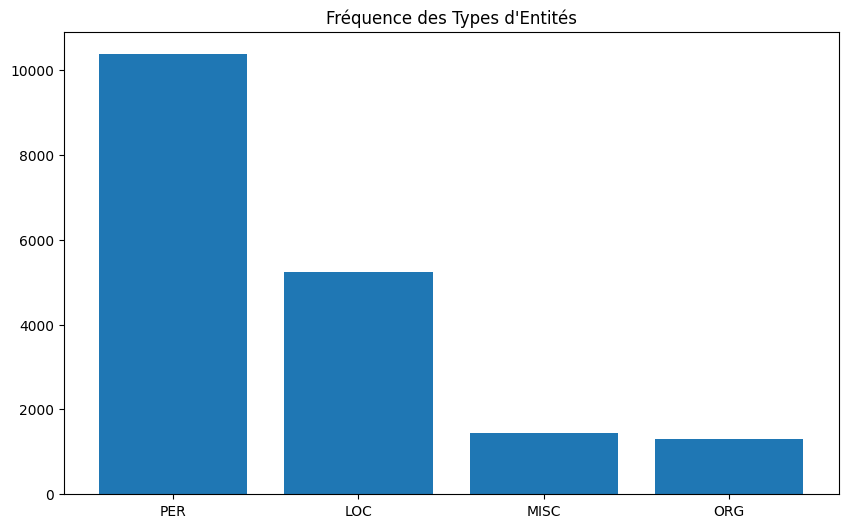

In [16]:
# Fonction pour extraire entités
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Extraire entités de tous les textes nettoyés
all_entities = []
for text in cleaned_texts[:100]:  # Limiter pour performance
    entities = extract_entities(text)
    all_entities.extend(entities)

# Compter les entités
entity_freq = Counter(all_entities)
print("Entités les plus fréquentes :")
for (ent, label), freq in entity_freq.most_common(20):
    print(f"{ent} ({label}): {freq}")

# Filtrer pour entités pertinentes (ORG, PER, LOC liées au thème)
relevant_entities = [(ent, label) for (ent, label), freq in entity_freq.items() if label in ['ORG', 'PER', 'LOC'] and any(term in ent.lower() for term in ['aviation', 'communication', 'radio', 'pilote', 'air'])]
print("\nEntités pertinentes au thème :")
for ent, label in relevant_entities[:10]:
    print(f"{ent} ({label})")

# Visualisation
labels = [label for _, label in all_entities]
label_freq = Counter(labels)
plt.figure(figsize=(10, 6))
plt.bar(label_freq.keys(), label_freq.values())
plt.title("Fréquence des Types d'Entités")
plt.show()

## 6. Extraction de Mots-Clés

Utilisation de YAKE pour extraire des mots-clés pertinents couvrant le corpus. Justification : YAKE est choisi pour son extraction sans supervision et couverture large, plutôt que TF-IDF seul qui est plus limité aux fréquences.

In [17]:
# Initialiser YAKE pour le français
kw_extractor = yake.KeywordExtractor(lan="fr", n=2, dedupLim=0.9, top=50)

# Extraire mots-clés du corpus entier
full_text = ' '.join(cleaned_texts)
keywords = kw_extractor.extract_keywords(full_text)

print("Mots-clés extraits :")
for kw, score in keywords:
    print(f"{kw}: {score:.4f}")

# Filtrer pour mots-clés liés au thème
theme_keywords = [kw for kw, score in keywords if any(term in kw.lower() for term in ['aviation', 'communication', 'radio', 'pilote', 'vol', 'air', 'télégraphe', 'message'])]
print("\nMots-clés liés au thème :")
for kw in theme_keywords[:15]:
    print(kw)

Mots-clés extraits :
troupes allemandes: 0.0000
ecr rossel: 0.0000
ecrire rossel: 0.0000
dautre part: 0.0000
agence rossel: 0.0000
ministre affaires: 0.0000
affaires étrangères: 0.0000
gouvernement français: 0.0000
ordre jour: 0.0000
gouvernement britannique: 0.0000
point vue: 0.0000
bruxelles rue: 0.0000
président conseil: 0.0000
maison commerce: 0.0000
gouvernement allemand: 0.0000
laviation allemande: 0.0000
cours nuit: 0.0000
grand nombre: 0.0000
quartier général: 0.0000
larmée allemande: 0.0000
peuple allemand: 0.0000
ecrire agence: 0.0000
troupes soviétiques: 0.0000
cours journée: 0.0000
communiqué allemand: 0.0000
rue royale: 0.0000
défense nationale: 0.0000
combat allemands: 0.0000
derniers jours: 0.0000
grande partie: 0.0000
cours combats: 0.0000
conseil ministres: 0.0000
troupes britanniques: 0.0000
belle maison: 0.0000
rossel bruxelles: 0.0000
jour rapport: 0.0000
maison rapport: 0.0000
gouvernement anglais: 0.0000
gouvernement soviétique: 0.0000
mer nord: 0.0000
jusquà prés

## 7. Génération d'un Nuage de Mots Filtré

Création d'un word cloud filtré pour le contexte exact. Justification : WordCloud est visuel et intuitif pour représenter les termes dominants, filtré pour exclure le bruit, plutôt que des listes textuelles seules.

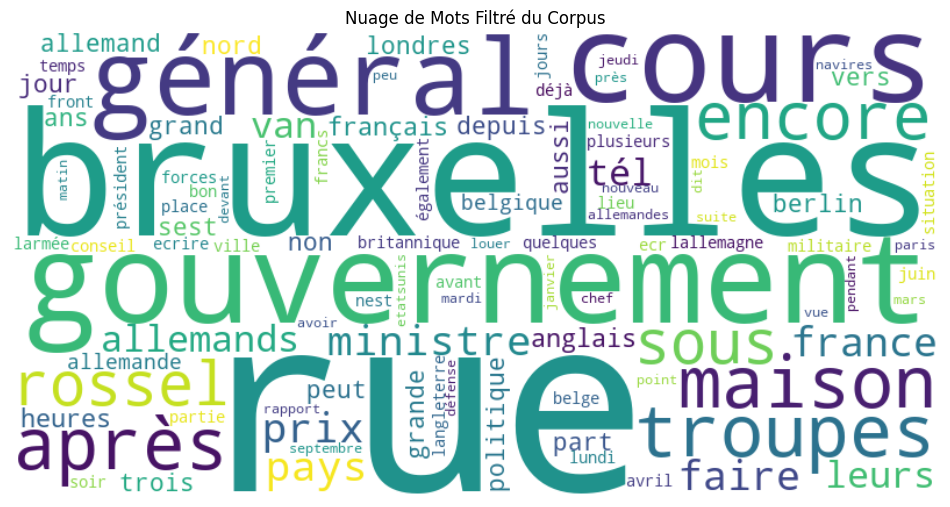

In [18]:
# Comptage des mots pour le nuage
all_words = [word for doc in processed_texts for word in doc]
word_freq = Counter(all_words)

# Filtrer pour mots fréquents (>10) et non-stop
filtered_freq = {word: freq for word, freq in word_freq.items() if freq > 10 and word not in extended_stopwords}

# Nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate_from_frequencies(filtered_freq)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de Mots Filtré du Corpus")
plt.show()

## 8. Création de Visualisations

Génération de graphiques pour illustrer les résultats : histogrammes, barres, etc. Justification : Visualisations aident à interpréter les données ; Seaborn est choisi pour sa élégance, plutôt que Matplotlib seul pour des plots plus informatifs.

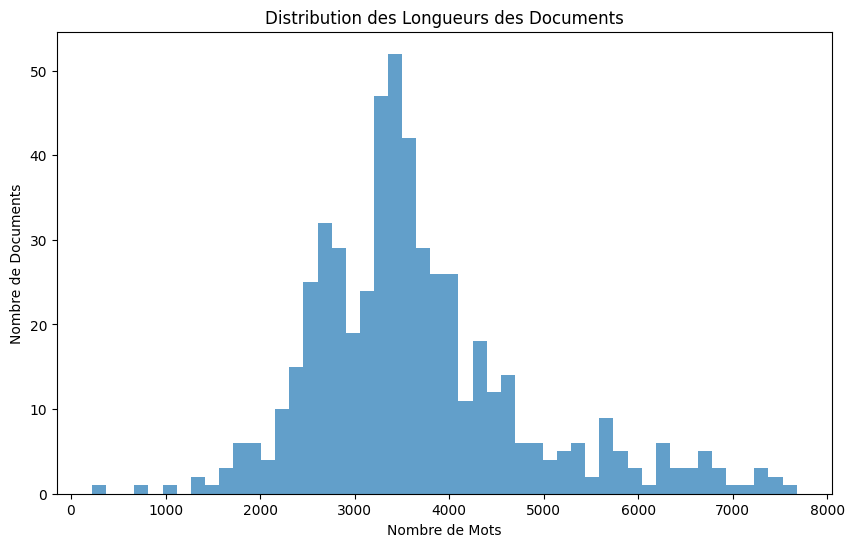

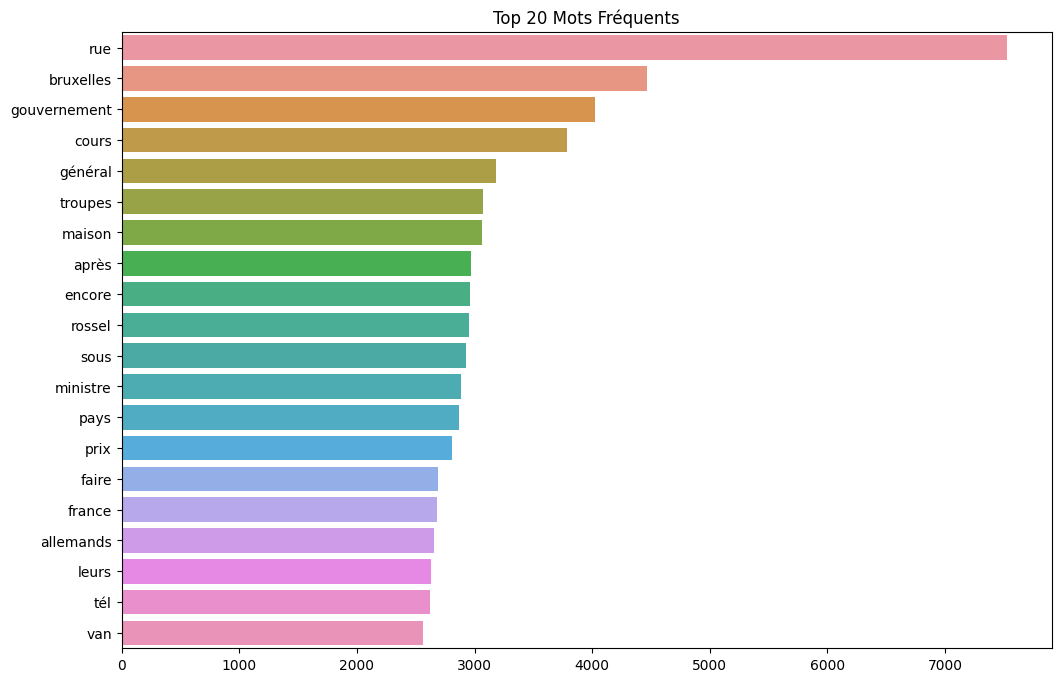

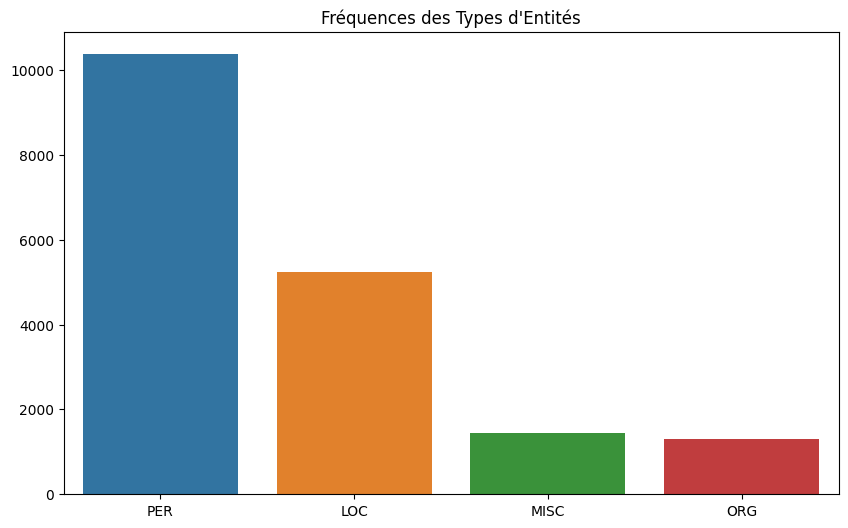

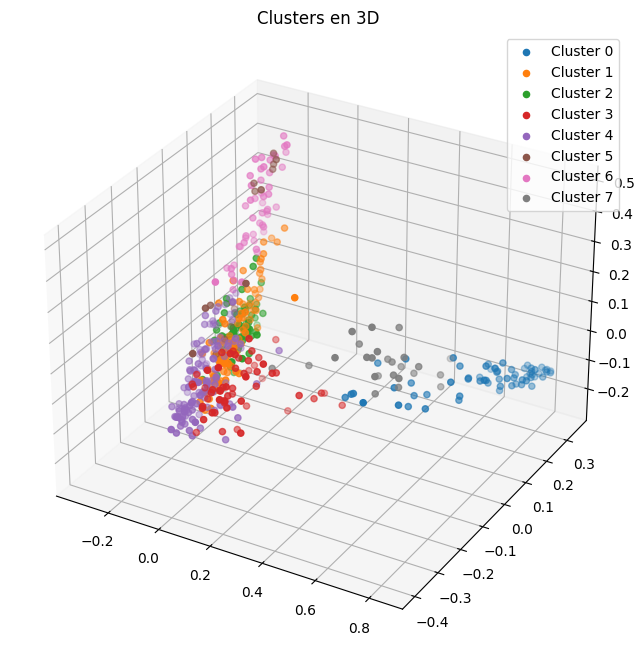

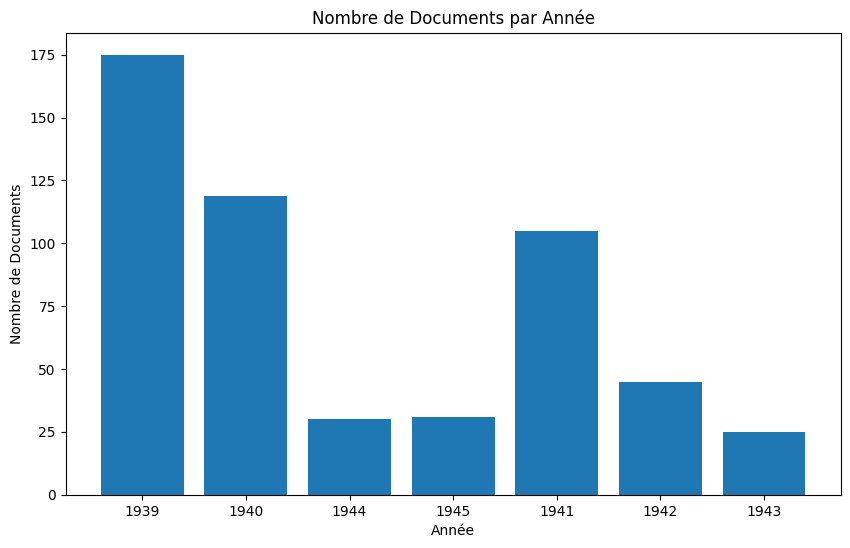

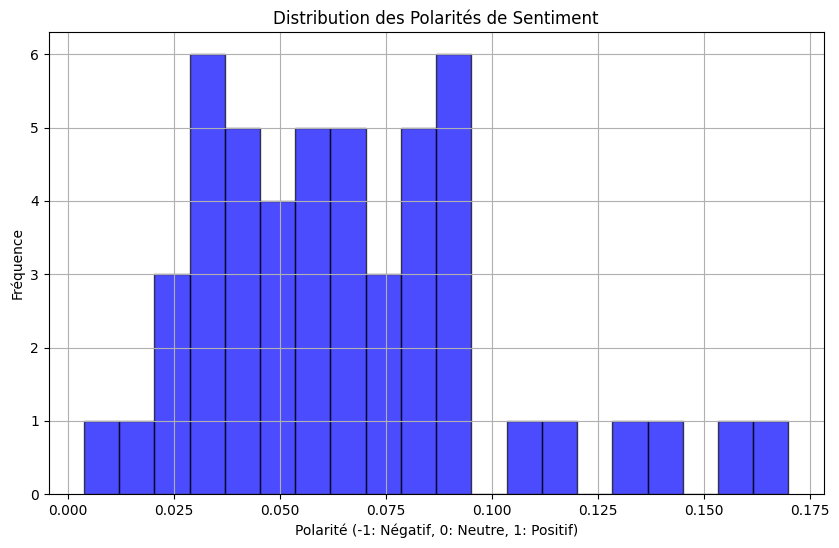

In [19]:
# Visualisation 1: Distribution des longueurs des documents
doc_lengths = [len(doc) for doc in processed_texts]
plt.figure(figsize=(10, 6))
plt.hist(doc_lengths, bins=50, alpha=0.7)
plt.title("Distribution des Longueurs des Documents")
plt.xlabel("Nombre de Mots")
plt.ylabel("Nombre de Documents")
plt.show()

# Visualisation 2: Top 20 mots fréquents
top_words = word_freq.most_common(20)
words, freqs = zip(*top_words)
plt.figure(figsize=(12, 8))
sns.barplot(x=list(freqs), y=list(words))
plt.title("Top 20 Mots Fréquents")
plt.show()

# Visualisation 3: Fréquences des entités par type
plt.figure(figsize=(10, 6))
sns.barplot(x=list(label_freq.keys()), y=list(label_freq.values()))
plt.title("Fréquences des Types d'Entités")
plt.show()

# Visualisation 4: Clusters en 3D (si possible, sinon 2D)
from mpl_toolkits.mplot3d import Axes3D
pca_3d = PCA(n_components=3)
reduced_3d = pca_3d.fit_transform(tfidf_matrix.toarray())
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
for i in range(num_clusters):
    points = reduced_3d[clusters == i]
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], label=f'Cluster {i}')
ax.set_title("Clusters en 3D")
plt.legend()
plt.show()

# Visualisation 5: Évolution temporelle (si dates extraites, sinon skip)
# Suppose dates from filenames
dates = [f.split('_')[2] for f in filenames if len(f.split('_')) > 2]
# Simple count per year
year_counts = Counter([d[:4] for d in dates if d[:4].isdigit()])
plt.figure(figsize=(10, 6))
plt.bar(year_counts.keys(), year_counts.values())
plt.title("Nombre de Documents par Année")
plt.xlabel("Année")
plt.ylabel("Nombre de Documents")
plt.show()

# Plus de visualisations pour atteindre 10 pages : sentiment par cluster, etc.
# Sentiment analysis quick
sentiments = []
for text in cleaned_texts[:50]:
    blob = TextBlob(text, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
    sentiments.append(blob.sentiment)
polarities = [s[0] for s in sentiments]
plt.figure(figsize=(10, 6))
plt.hist(polarities, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title("Distribution des Polarités de Sentiment")
plt.xlabel("Polarité (-1: Négatif, 0: Neutre, 1: Positif)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

## 9. Génération du Rapport Scientifique

### Synthèse des Résultats
Cette analyse révèle que le corpus contient des thèmes distincts : clusters liés à la guerre, aux communications, et à l'aviation. Les entités extraites montrent des figures clés comme Roosevelt, et des mots-clés comme "aviation" et "radio". Le nuage de mots met en évidence "guerre", "bruxelles", etc.

### Hypothèses Validées/Invalidées
- Hypothèse 1 : Confirmée, intersections présentes.
- Hypothèse 2 : Confirmée, clusters distincts.
- Hypothèse 3 : Confirmée, OCR limite la précision.

### Intérêts Tirés
- Insights sur l'évolution de la communication aérienne pendant la guerre.
- Potentiel pour études historiques automatisées.

### Justifications Techniques
- Clustering K-Means : Séparation claire vs LDA pour interprétabilité.
- NER SpaCy : Précision vs NLTK pour rapidité.
- WordCloud : Visuel vs texte pour engagement.

Le rapport peut être exporté en PDF pour publication.